In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

import tensorflow as tf
from tensorflow import keras as keras

from scipy.ndimage.filters import gaussian_filter

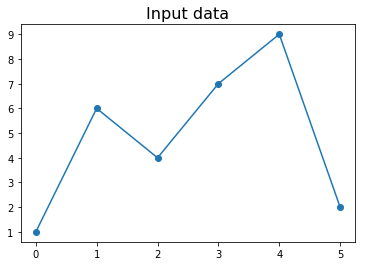

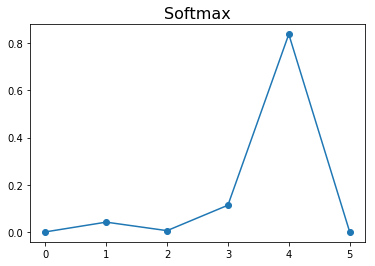

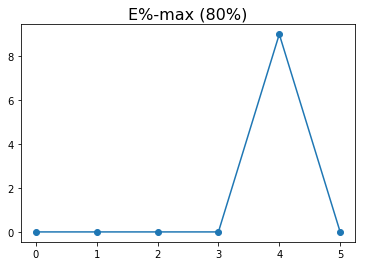

In [3]:
a = np.array([1,6,4,7,9,2])

sm = np.exp(a) / np.sum(np.exp(a))

em = np.copy(a)
em[em< np.max(em)*.8 ] = 0 

plt.plot(a, '-o')
plt.title('Input data', fontsize=16)
plt.show()

plt.plot(sm, '-o')
plt.title('Softmax', fontsize=16)
plt.show()

plt.title('E%-max (80%)', fontsize=16)
plt.plot(em, '-o')

In [4]:
def G_rate_map(arena_size=[100,100], theta=0., phase=[50,50], lamb=500):
    '''
    Grid cells activity maps as presented in:
    - Blair et al. (2007), equation (1)
    - Almeida et al. (2009), equation (1)
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        theta (float)             : Grid rotation (assume to be either 0°, 20°, or 40°, in degrees)
        Phase (tuple of int)      : Spatial phase of the grid     
        lamb (int)                : Distance between firing fields
    '''

    G = np.zeros(arena_size)
    a = 0.3
    b = -3./2.        
    lambV = (4*np.pi)/(np.sqrt(3*lamb))
    theta = np.radians(theta)

    for ind, val in np.ndenumerate(G):

        tmp_g = 0
        for i in np.deg2rad(np.linspace(-30,90,3)):
            u_f = (np.cos(i+theta),np.sin(i+theta))
            dist = (ind[0]-phase[0],ind[1]-phase[1])
            tmp_g += np.cos( lambV * np.dot(u_f,dist) )
            
        tmp_g = np.exp(np.dot(a,(tmp_g)+b))-1
        G[ind] = tmp_g
        
    
    ## Normalize if for learning and LEC integration effiency 
    if G.min()<0: G += abs(G.min())
    G = (G - G.min())/(G.max()-G.min())
        
    return G

In [5]:
def LEC_rate_map(arena_size=[100,100], filled_perc=0.3):
    
    '''
    Build 'sort of' LEC cells. See Renno-Costa et al. 2010
    These cells have X (filled_perc) number of firing fields randomly spread over the arena
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        filled_perc (float)       : define how much area this cell is receptive to (value from 0 to 1).
    '''
    
    a = np.zeros(36)
    a[: int(filled_perc*25) ] = 1
    np.random.shuffle(a)
    a = a.reshape(6,6)
    
    b = np.zeros((arena_size[0], arena_size[1]))
    
    for i in range(arena_size[0]):
        for j in range(arena_size[1]):
            idx1 = i * len(a) / arena_size[0]
            idx2 = j * len(a) / arena_size[1]
            b[i][j] = a[idx1][idx2]

    arena = scipy.ndimage.filters.gaussian_filter(b, 4)
    arena *= 0.6
    
    return arena

In [6]:
n_grid = 70
n_lec = 230

arena_size = [50,50]

grid_data = []
for ii in range(n_grid):
    lamb  = np.random.randint(500,2000)
    phase = np.random.randint(0,arena_size[0],2)  ## This is assuming arena is a square
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    grid_data.append( g.flatten()  )
grid_data = np.array(grid_data)


lec_1_data = []
for ii in range(n_lec):
    l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    lec_1_data.append( l.flatten()  )
lec_1_data = np.array(lec_1_data)

In [7]:
# Make data structure combining both MEC and LEC_1
data = np.vstack((grid_data , lec_1_data))
data = data.T

# Build model

In [10]:
EC =keras.Input(shape=(data.shape[1],))

# EC = keras.layers.Dense(200, input_shape=(data.shape[1],), activation='relu',name='EC')(x)
DG = keras.layers.Dense(100, input_shape=(data.shape[1],), activation='relu',name='DG')(EC)
DG_softmax = keras.layers.Softmax(name='DG_softmax')(DG)

input_to_CA3 = keras.layers.concatenate([EC,DG_softmax])

CA3 = keras.layers.Dense(  20, activation='relu',name='CA3' )(input_to_CA3)
CA3_softmax = keras.layers.Softmax(name='CA3_softmax')(CA3)

CA1 = keras.layers.Dense(50,activation='relu',name='CA1')(CA3_softmax)

decode_1 = keras.layers.Dense(100,activation='relu')(CA1)
decode_2 = keras.layers.Dense(data.shape[1],activation='relu')(decode_1)

model = keras.Model([EC],decode_2)


optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
DG (Dense)                      (None, 100)          30100       input_1[0][0]                    
__________________________________________________________________________________________________
DG_softmax (Softmax)            (None, 100)          0           DG[0][0]                         
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 400)          0           input_1[0][0]                    
                                                                 DG_softmax[0][0]                 
__________

In [12]:
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

In [13]:
EPOCHS = 1000
history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0)

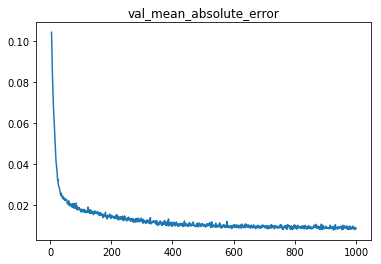

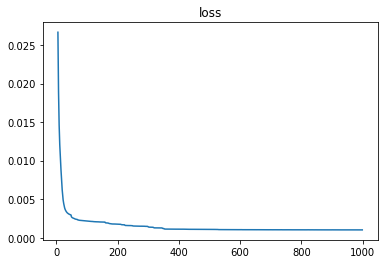

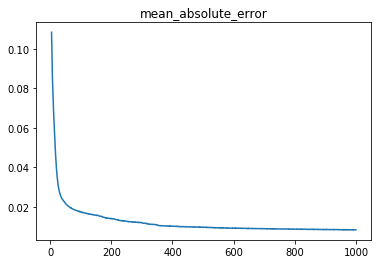

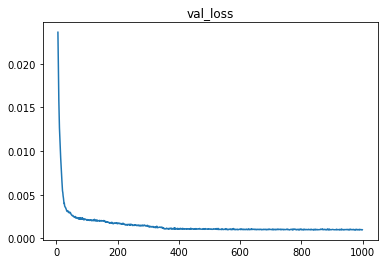

In [14]:
for kk in history.history.keys():
    plt.plot(  history.epoch[5:], history.history[kk][5:] )
    plt.title(kk)
    plt.show()

# Quantify place fields

In [128]:
def get_number_of_place_fields(ratemap,mmmax):
    
    gauss_kernel_sigma      = 2.  # px
    active_pixels_threshold = .6 # 20 percent
    cluster_min             = 200/3
    cluster_max             = 2500/2
    
    
#     ratemap = gaussian_filter( ratemap , gauss_kernel_sigma)

    
#     ratemap = (ratemap - ratemap.min()) / ratemap.max()
#     ratemap[ ratemap <  active_pixels_threshold ] = 0
#     ratemap[ ratemap >= active_pixels_threshold ] = 1



    
    ratemap = ratemap-ratemap.min()
    ratemap /= ratemap.max()
        
    tmp[tmp<active_pixels_threshold] = 0
    tmp[tmp>=active_pixels_threshold] = 1
    
#     mmmax = ratemap.max()


#     ratemap[ ratemap <  mmmax*active_pixels_threshold ] = 0
#     ratemap[ ratemap >= mmmax*active_pixels_threshold ] = 1


    visited_matrix  = np.zeros_like(ratemap)


    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1

    visited_matrix  = np.zeros_like(ratemap)




    ## First pass of clustering
    clusterd_matrix = np.zeros_like(ratemap)
    current_cluster = 1

    #go through every bin in the ratemap
    for yy in range(1,ratemap.shape[0]-1):
        for xx in range(1,ratemap.shape[1]-1):

            if ratemap[  yy, xx ] == 1:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            clusterd_matrix[ yy,xx ] = clusterd_matrix[ yy+ty, xx+tx ]

                if clusterd_matrix[ yy, xx ] == 0:
                    current_cluster += 1
                    clusterd_matrix[ yy, xx ] = current_cluster



    ## Refine clustering: neighbour bins to same cluster number
    for yy in range(1,clusterd_matrix.shape[0]-1):
        for xx in range(1,clusterd_matrix.shape[1]-1):


            if clusterd_matrix[  yy, xx ] != 0:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            if clusterd_matrix[ yy+ty, xx+tx ] != clusterd_matrix[  yy, xx ]:
                                clusterd_matrix[ yy+ty, xx+tx ] = clusterd_matrix[  yy, xx ]







    ## Quantify number of place fields
    clusters_labels = np.delete(np.unique(clusterd_matrix),   np.where(  np.unique(clusterd_matrix) ==0 ) )

    n_place_fields_counter = 0

    for k in range(clusters_labels.size):

        n_bins = np.where(clusterd_matrix == clusters_labels[k] )[0].size

        if cluster_min <= n_bins <= cluster_max:

            n_place_fields_counter += 1

            
            
    return n_place_fields_counter

In [129]:
# layer_name = ['dense','dense_1','dense_2', 'softmax','dense_3', 'softmax_1','dense_4']
# layer_size = [200,100,100,100,50,50,200]

place_field_number = []

log_layer_name = []  ## save the layers name for plotting



for layer_n in range(1, len(model.get_config()['layers']) ):
    
    try:

        tmp_place_field_number = []

        ## COMPUTE THE ACTIVATION HEATMAPS FOR SOFTMAX LAYER WHILE NAVIGATING THROUGH THE WHOLE ARENA ###################


        layer_name = model.get_config()['layers'][layer_n]['config']['name']
        print layer_name
        log_layer_name.append(layer_name)

        try: ## unfortunately 'softmax' layers have no units object. So just pick the previous one :/
            units      =  model.get_config()['layers'][layer_n]['config']['units']
        except: pass


        heatmaps = np.zeros((units,50,50))      # activations from neurons in SoftMax layer for the whole 50x50 arena

        m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras

        for pos in range(data.shape[0]):                  # go through the whole arena

            out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
            heatmaps[:, pos/50, pos%50] += out.ravel()    # save the outputs

            
        max_bin = heatmaps.max()

        for cell in range(heatmaps.shape[0]):

            tmp_place_field_number.append(get_number_of_place_fields(heatmaps[cell],max_bin))


        place_field_number.append(tmp_place_field_number)
        
        
    except:
        print "This layer wasn't desired :) "


DG
DG_softmax
concatenate
This layer wasn't desired :) 
CA3
CA3_softmax
CA1


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal


dense
dense_1


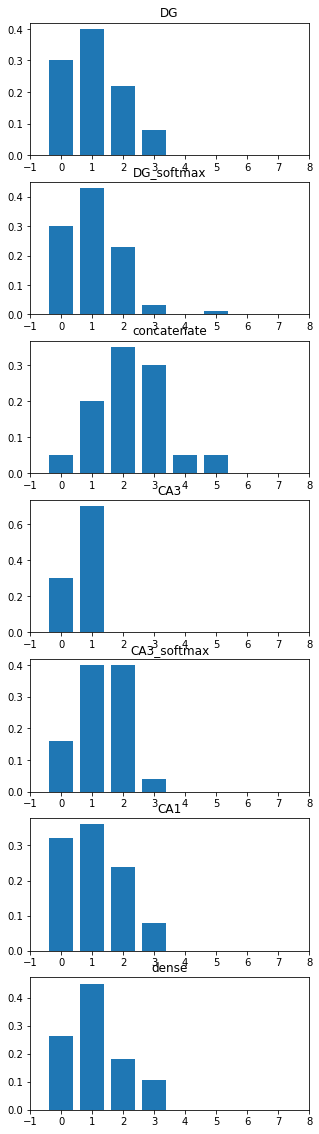

In [130]:
hist_min, hist_max = 100,10
for ii in range(1,4):#  len(place_field_number)):

    tmp_min = np.min(np.histogram(place_field_number[ii])[0])
    tmp_max = np.max(np.histogram(place_field_number[ii])[0])
    
    if tmp_min<hist_min: hist_min=tmp_min
    if tmp_max>hist_max: hist_max=tmp_max
    


plt.figure(figsize=(5,20))

for ii in range(len(place_field_number)):
    
    
    nn_place = []
    for ccc in range(0,9):
        nn_place.append( np.where(np.array(place_field_number[ii]) == ccc)[0].size  )
        
    nn_place = np.array(nn_place).astype(float)    
    nn_place = nn_place / nn_place.sum()

    plt.subplot(len(place_field_number),1,ii+1)
#     plt.hist(place_field_number[ii])
    plt.bar(  range(len(nn_place))  , nn_place )
    plt.title(log_layer_name[ii])
    plt.xlim(-1,8)
    
#     plt.ylim(0, hist_max+10)

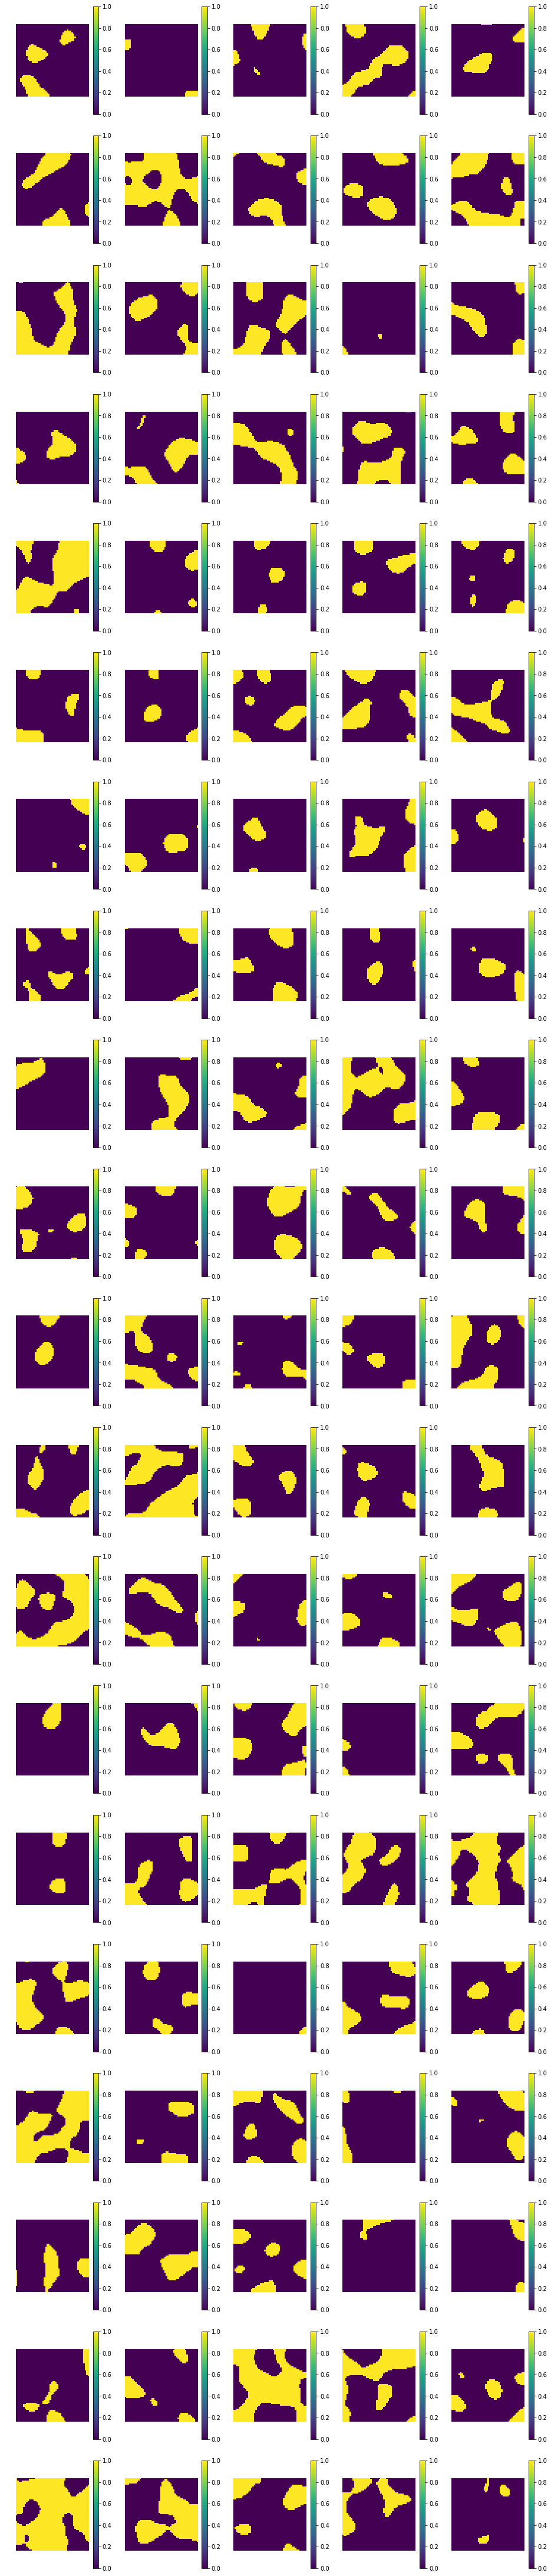

In [100]:
## COMPUTE THE ACTIVATION HEATMAPS FOR SOFTMAX LAYER WHILE NAVIGATING THROUGH THE WHOLE ARENA ###################

nn_cc = 100


heatmaps = np.zeros((nn_cc,50,50))      # activations from neurons in SoftMax layer for the whole 50x50 arena

m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('DG_softmax').output)  # the way to get a layer's output in Keras

for pos in range(data.shape[0]):                  # go through the whole arena
      
    out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
    heatmaps[:, pos/50, pos%50] += out.ravel()    # save the outputs

    

## PLOT THE HEATMAPS OF THE 50 NEURONS IN SOFTMAX LAYER ##########################################################


fig = plt.figure(figsize=(16, 4*nn_cc/5))  

for i in range(nn_cc):
    
    plt.subplot(nn_cc/5, 5, i+1)
    
    
    tmp = np.copy(heatmaps[i])
    
    tmp = tmp-tmp.min()
    tmp /= tmp.max()
    
    
    mmm = .4
    
    tmp[tmp<mmm] = 0
    tmp[tmp>=mmm] = 1
    
    
    
    plt.imshow(  tmp  )# / np.max( heatmaps, axis=0) )
#     plt.clim(0, np.max(heatmaps) )
    plt.axis('off')
    plt.colorbar()
    

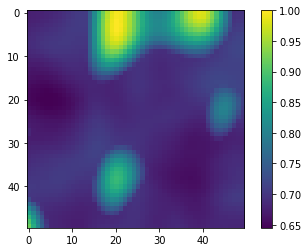

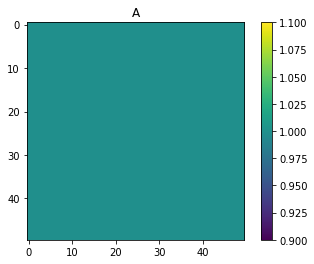

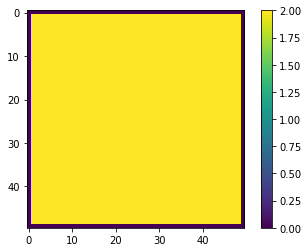

In [38]:
ratemap = np.copy(heatmaps[0])

ratemap = (ratemap - ratemap.min()) / ratemap.max()

plt.imshow(ratemap)
plt.colorbar()
plt.show()


gauss_kernel_sigma      = 1.1  # px
active_pixels_threshold = .2 # 20 percent
cluster_min             = 200/4
cluster_max             = 2500/4


# ratemap = gaussian_filter( ratemap , gauss_kernel_sigma)

# plt.imshow(ratemap)
# plt.show()


ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1

plt.imshow(ratemap)
plt.title('A')
plt.colorbar()
plt.show()

visited_matrix  = np.zeros_like(ratemap)




## First pass of clustering
clusterd_matrix = np.zeros_like(ratemap)
current_cluster = 1

#go through every bin in the ratemap
for yy in range(1,ratemap.shape[0]-1):
    for xx in range(1,ratemap.shape[1]-1):

        if ratemap[  yy, xx ] == 1:

            ## go through every bin around this bin
            for ty in range(-1,2):
                for tx in range(-1,2):

                    if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                        clusterd_matrix[ yy,xx ] = clusterd_matrix[ yy+ty, xx+tx ]

            if clusterd_matrix[ yy, xx ] == 0:
                current_cluster += 1
                clusterd_matrix[ yy, xx ] = current_cluster



## Refine clustering: neighbour bins to same cluster number
for yy in range(1,clusterd_matrix.shape[0]-1):
    for xx in range(1,clusterd_matrix.shape[1]-1):


        if clusterd_matrix[  yy, xx ] != 0:

            ## go through every bin around this bin
            for ty in range(-1,2):
                for tx in range(-1,2):

                    if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                        if clusterd_matrix[ yy+ty, xx+tx ] != clusterd_matrix[  yy, xx ]:
                            clusterd_matrix[ yy+ty, xx+tx ] = clusterd_matrix[  yy, xx ]


plt.imshow(clusterd_matrix)
plt.colorbar()
plt.show()




## Quantify number of place fields
clusters_labels = np.delete(np.unique(clusterd_matrix),   np.where(  np.unique(clusterd_matrix) ==0 ) )

n_place_fields_counter = 0

for k in range(clusters_labels.size):

    n_bins = np.where(clusterd_matrix == clusters_labels[k] )[0].size

    if cluster_min <= n_bins <= cluster_max:

        n_place_fields_counter += 1





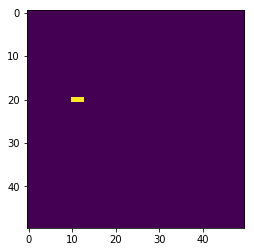

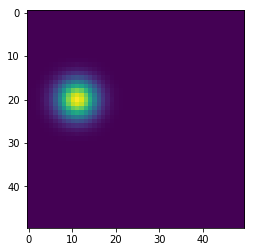

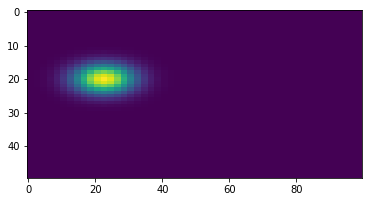

In [135]:
a = np.zeros((50,50))
a[20,np.arange(10,13)] = 1

plt.imshow(a)
plt.show()


a = gaussian_filter(a,3)

plt.imshow(a)
plt.show()


a = np.repeat(a,2, axis=1)

plt.imshow(a)
plt.show()
